In [36]:
import torch
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
words = open('names.txt').read().splitlines()

In [ ]:
len(words)

In [38]:
# build vocab of characters and mappings to / from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: 'ó', 28: 'ę', 29: 'ł', 30: 'ń', 31: 'ś', 32: 'ż', 0: '.'}
33


In [9]:
import random
# build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))  
n2 = int(0.9 * len(words))
Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [ ]:
# MLP code from last project
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) #Kaiming initialization
b1 = torch.randn(n_hidden, generator=g) * 0.01 # b1 is small at initialization
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # W2 is small at initialization
b2 = torch.randn(vocab_size, generator=g) * 0 # b2 is zero at initialization

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad_()

In [ ]:
# training loop
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # create minibatch
    ix = torch.randint(0, Xtrain.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi) + bnbias # batch normalization

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update weights
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 1000 == 0:
        lossi.append(loss.item())
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

In [ ]:
plt.plot(lossi)

In [9]:
# I already implemented it in straining stage using running mean and std

# # calibrating batch normalization after training loop

# with torch.no_grad():
#     emb = C[Xtrain]
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 + b1
#     # measure mean and std over entire training set
#     bnmean = hpreact.mean(dim=0, keepdim=True)
#     bnstd = hpreact.std(dim=0, keepdim=True)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias # batch normalization
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias # batch normalization
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out[:-1]))

## structuring code so it look more like pytorch

In [56]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in**0.5) 
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class LeakyRelu:
    def __call__(self, x):
        self.out = torch.nn.functional.leaky_relu(x)
        return self.out
    
    def parameters(self):
        return []

In [84]:
n_embd = 10
n_hidden = 100
block_size = 3
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), LeakyRelu(),
    Linear(n_hidden, n_hidden), LeakyRelu(),
    Linear(n_hidden, n_hidden), LeakyRelu(),
    Linear(n_hidden, n_hidden), LeakyRelu(),
    Linear(n_hidden, n_hidden), LeakyRelu(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight /= 10
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= np.sqrt(2 / (1 + (0.01)**2))

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47163


In [89]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtrain.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    if i % 1000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    if i > 1000:
        break

      0/ 200000: 3.2309
   1000/ 200000: 2.7728


layer 1 ( LeakyRelu): mean +0.55, std 0.84, saturated: 26.88%
layer 3 ( LeakyRelu): mean +0.40, std 0.74, saturated: 26.78%
layer 5 ( LeakyRelu): mean +0.35, std 0.65, saturated: 32.47%
layer 7 ( LeakyRelu): mean +0.36, std 0.62, saturated: 36.41%
layer 9 ( LeakyRelu): mean +0.32, std 0.58, saturated: 39.94%


Text(0.5, 1.0, 'activation distribution')

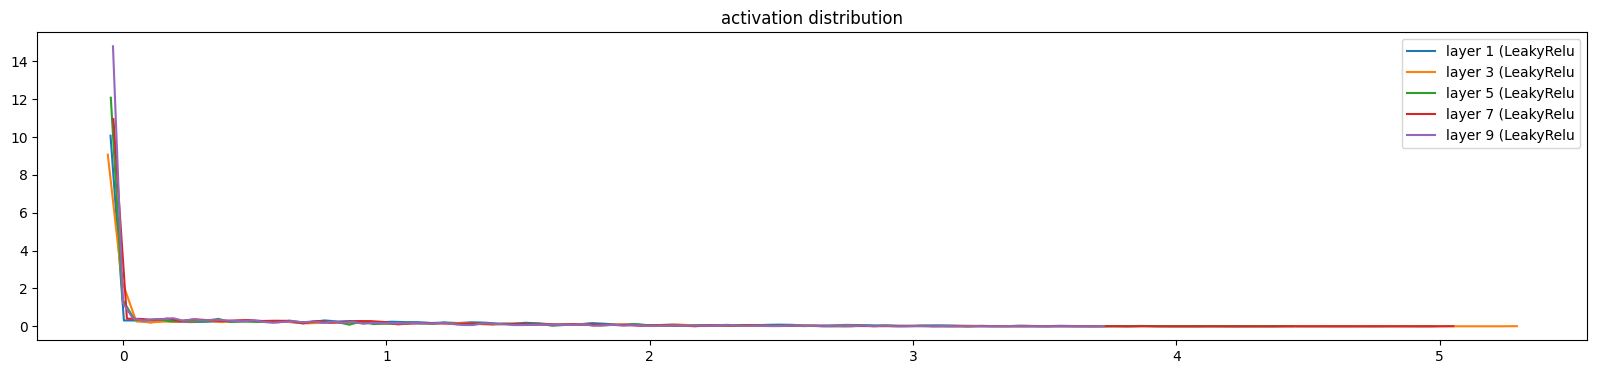

In [90]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, LeakyRelu):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() < 0.01).float().mean() * 100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

layer 1 ( LeakyRelu): mean +0.000129, std 3.689921e-03
layer 3 ( LeakyRelu): mean +0.000064, std 3.137219e-03
layer 5 ( LeakyRelu): mean +0.000039, std 2.905624e-03
layer 7 ( LeakyRelu): mean +0.000063, std 2.558476e-03
layer 9 ( LeakyRelu): mean +0.000048, std 2.220250e-03


Text(0.5, 1.0, 'gradient distribution')

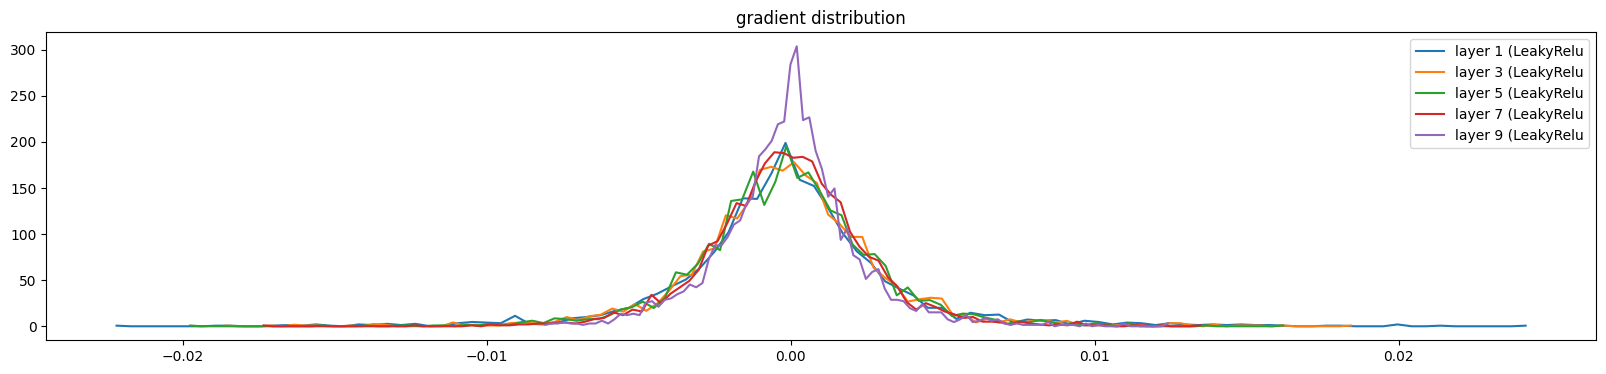

In [91]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, LeakyRelu):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (33, 10) | mean -0.000501 | std 1.531474e-02 | grad:data ratio 1.541532e-02
weight  (30, 100) | mean -0.000286 | std 1.782296e-02 | grad:data ratio 6.835722e-02
weight (100, 100) | mean +0.000504 | std 1.659677e-02 | grad:data ratio 1.149961e-01
weight (100, 100) | mean +0.000252 | std 1.271774e-02 | grad:data ratio 8.898900e-02
weight (100, 100) | mean +0.001123 | std 1.017181e-02 | grad:data ratio 7.141595e-02
weight (100, 100) | mean +0.000837 | std 7.871334e-03 | grad:data ratio 5.542369e-02
weight  (100, 33) | mean -0.000000 | std 2.010667e-02 | grad:data ratio 2.928857e-01


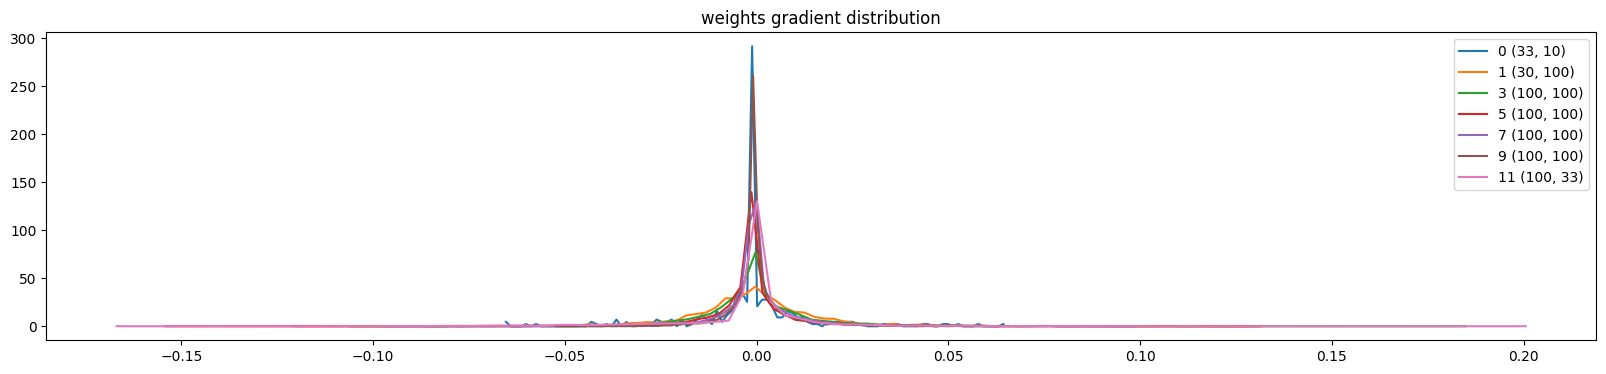

In [92]:

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');